In [ ]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Just like the way we did it in class (Module 5- Python 3 notebook), go to the KaggleLinks to an external site. website and download the data. (5 points)

In [ ]:
from google.colab import files
files.upload()
!cat kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


Saving kaggle.json to kaggle.json
{"username":"anneliserasmussen","key":"563dfdb55712f9255a1dfa164a27cceb"}

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d destination_folder


Streaming output truncated to the last 5000 lines.
  inflating: destination_folder/seg_train/seg_train/mountain/7506.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7537.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7539.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7551.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7560.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7565.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7578.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7581.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7586.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7647.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7652.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7654.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7662.jpg  
  inflating: 

You need to make the relevant directories (train, validation, test) and copy images from the original directory to this new subdirectories you just created. Make sure you copy 1000 images of each class for the train, 500 for validation and 1000 images for the test data directory. (10 points)

In [ ]:
import os
import shutil
from random import sample

# Define the base directory
base_dir = '/content/destination_folder'

# Define the original and new directories
original_train_dir = os.path.join(base_dir, 'seg_train', 'seg_train')


new_train_dir = os.path.join(base_dir, 'train')
new_val_dir = os.path.join(base_dir, 'validation')
new_test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Create the new directories
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# List of classes
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Function to copy images
def copy_images(orig_dir, new_dir, start_index, num_images):
    for cls in classes:
        cls_dir = os.path.join(orig_dir, cls)
        images = sorted(os.listdir(cls_dir))  # Sort the images
        selected_images = images[start_index:start_index + num_images]

        print(f"Copying {len(selected_images)} images from class '{cls}'...")

        os.makedirs(os.path.join(new_dir, cls), exist_ok=True)
        for img in selected_images:
            src_path = os.path.join(cls_dir, img)
            dest_path = os.path.join(new_dir, cls, img)
            shutil.copy(src_path, dest_path)

        print(f"Done copying class '{cls}'.\n")
copy_images(original_train_dir, new_train_dir, 0, 1000)        # 1000 images per class for train
copy_images(original_train_dir, new_val_dir, 1000, 500)        # Next 500 images per class for validation
copy_images(original_train_dir, new_test_dir, 1500, 1000)

Copying 1000 images from class 'buildings'...
Done copying class 'buildings'.

Copying 1000 images from class 'forest'...
Done copying class 'forest'.

Copying 1000 images from class 'glacier'...
Done copying class 'glacier'.

Copying 1000 images from class 'mountain'...
Done copying class 'mountain'.

Copying 1000 images from class 'sea'...
Done copying class 'sea'.

Copying 1000 images from class 'street'...
Done copying class 'street'.

Copying 500 images from class 'buildings'...
Done copying class 'buildings'.

Copying 500 images from class 'forest'...
Done copying class 'forest'.

Copying 500 images from class 'glacier'...
Done copying class 'glacier'.

Copying 500 images from class 'mountain'...
Done copying class 'mountain'.

Copying 500 images from class 'sea'...
Done copying class 'sea'.

Copying 500 images from class 'street'...
Done copying class 'street'.

Copying 691 images from class 'buildings'...
Done copying class 'buildings'.

Copying 771 images from class 'forest'..

Using the image_dataset_from_directory() function from tensorflow.keras.util, reshape your images into 180*180 size and batches of size 32. You should create 3 data sets. Train_dataset, Validation_dataset and Test_dataset. If you do this step correctly, you should see something like this: (5 points)

Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 5022 files belonging to 6 classes.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
# Define the batch size and the target image size
batch_size = 32
img_size = (180, 180)

# Create the train dataset
train_dataset = image_dataset_from_directory(
    directory=new_train_dir,
    batch_size=batch_size,
    image_size=img_size)

# Create the validation dataset
validation_dataset = image_dataset_from_directory(
    directory=new_val_dir,
    batch_size=batch_size,
    image_size=img_size)

# Create the test dataset
test_dataset = image_dataset_from_directory(
    directory=new_test_dir,
    batch_size=batch_size,
    image_size=img_size)

Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 5022 files belonging to 6 classes.


2. The goal is to use transfer learning to improve our benchmark model. The benchmark model is a very simple CNN with no regularization or data augmentation. For the model architecture, feel free to use any reasonable numbers for the layers, neurons, filters and etc.
make sure you add Modelcheckpoint to your callback list when you are training the network using model.fit().
report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_benchmark.keras).  You don't need to plot the epoch vs accuracy graph or epoch vs loss graph at this stage.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping   = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath="cnn_base_model.h5")
callback_list    = [early_stopping,model_checkpoint]

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def build_cnn_model():
    inputs= keras.Input(shape= (180,180,3), name='Input layer')
    x = layers.Rescaling(1./255, name='rescaling')(inputs)
    x = layers.Conv2D(filters= 32, kernel_size = 3, strides = (1,1) , padding='same',  activation='relu' ,name="conv_layer_1")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_1")(x)
    x = layers.Conv2D(filters= 64, kernel_size = 3,  padding='same',activation='relu', name="conv_layer_2")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_2")(x)
    x = layers.Conv2D(filters= 128, kernel_size = 3, padding='same', activation='relu', name="conv_layer_3")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_3")(x)
    x = layers.Conv2D(filters= 256, kernel_size = 3, padding='same', activation='relu', name="conv_layer_4")(x)
    x = layers.Flatten(name="flattening_layer")(x)
    x = layers.Dense(units= 64, activation='relu')(x)
    outputs = layers.Dense(units= 6, activation='softmax', name='output_layer')(x)

    model = keras.Model(inputs= inputs , outputs=outputs, name='base_CNN_model')

    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
base_model = build_cnn_model()
base_model.summary()

Model: "base_CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 180, 180, 32)      896       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 90, 90, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 90, 90, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 45, 45, 64)        0         
                                                                 
 conv_layer_3 (Conv2D)       (None, 45, 45, 128)    

In [ ]:
history= base_model.fit(train_dataset, validation_data=validation_dataset, epochs=30, batch_size=32,
          callbacks=callback_list)

Epoch 1/30
188/188 [==============================] - 22s 58ms/step - loss: 1.5000 - accuracy: 0.4508 - val_loss: 1.1551 - val_accuracy: 0.5290


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
188/188 [==============================] - 13s 67ms/step - loss: 0.9945 - accuracy: 0.6230 - val_loss: 1.0464 - val_accuracy: 0.6010
Epoch 3/30
188/188 [==============================] - 10s 54ms/step - loss: 0.8206 - accuracy: 0.6907 - val_loss: 0.8730 - val_accuracy: 0.6410
Epoch 4/30
188/188 [==============================] - 10s 52ms/step - loss: 0.6827 - accuracy: 0.7498 - val_loss: 0.7546 - val_accuracy: 0.7310
Epoch 5/30
188/188 [==============================] - 10s 53ms/step - loss: 0.5606 - accuracy: 0.7898 - val_loss: 0.8185 - val_accuracy: 0.7273
Epoch 6/30
188/188 [==============================] - 11s 56ms/step - loss: 0.4596 - accuracy: 0.8342 - val_loss: 0.9466 - val_accuracy: 0.7127
Epoch 7/30
188/188 [==============================] - 14s 73ms/step - loss: 0.3530 - accuracy: 0.8755 - val_loss: 1.0825 - val_accuracy: 0.7237
Epoch 8/30
188/188 [==============================] - 11s 56ms/step - loss: 0.2627 - accuracy: 0.9090 - val_loss: 1.2565 - val_accuracy:

In [ ]:
test_model = keras.models.load_model("cnn_base_model.h5")
test_model.evaluate(test_dataset)

157/157 [==============================] - 4s 24ms/step - loss: 0.7292 - accuracy: 0.7320


[0.7291702032089233, 0.7319793105125427]

Benchmark accuracy : 0.7319 or 73.2%

3. Alright, now let's see if you can beat your benchmark accuracy by leveraging transfer learning!!

We will be applying two types of transfer learning:

1.feature extraction
2.fine tuning

Let's start by the feature extraction approach. Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.






generate features and labels for the train, validation and test datasets. (10 points)

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # this scales pixel values to an appropriate range.
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 25ms/step


create your own neural network! (the input of this dense network is the feature map created by your VGG16, Xception or any other network you picked to work with for transfer learning) (10 points)

In [ ]:
train_features.shape


(6000, 5, 5, 512)

In [ ]:
test_features.shape

(5022, 5, 5, 512)

In [ ]:
test_labels.shape

(5022,)

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               1638528   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
Total params: 1639302 (6.25 MB)
Trainable params: 1639302 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_features.shape

(6000, 5, 5, 512)

In [ ]:
val_features.shape

(3000, 5, 5, 512)

train your model using model.fit(). Make sure you save the best one by adding the modelcheckpoint to your callback list. (5 points)

In [ ]:
model_checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath="fe_cnn_model.h5")
callback_list    = [model_checkpoint]


In [ ]:
history2 = model.fit(train_features,train_labels,
                              epochs=20, validation_data=(val_features, val_labels),
                              callbacks=callback_list)

Epoch 1/20
188/188 [==============================] - 2s 7ms/step - loss: 10.6350 - accuracy: 0.8453 - val_loss: 7.5075 - val_accuracy: 0.8953
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 4.8124 - accuracy: 0.9155 - val_loss: 7.5404 - val_accuracy: 0.9020
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 3.1803 - accuracy: 0.9373 - val_loss: 6.8211 - val_accuracy: 0.9010
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 2.2220 - accuracy: 0.9462 - val_loss: 7.3334 - val_accuracy: 0.9007
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 1.6424 - accuracy: 0.9547 - val_loss: 6.9168 - val_accuracy: 0.9077
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 1.1405 - accuracy: 0.9647 - val_loss: 7.6141 - val_accuracy: 0.9010
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.9122 - accuracy: 0.9675 - val_loss: 7.7070 - val_accuracy: 0.8943
Epoch

plot the loss vs epoch graph! as well as accuracy vs epoch graph. (10 points)

In [ ]:
metrics = pd.DataFrame(history2.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,10.635009,0.845333,7.507513,0.895333
1,4.812386,0.915500,7.540360,0.902000
2,3.180347,0.937333,6.821054,0.901000
3,2.221956,0.946167,7.333425,0.900667
4,1.642365,0.954667,6.916779,0.907667


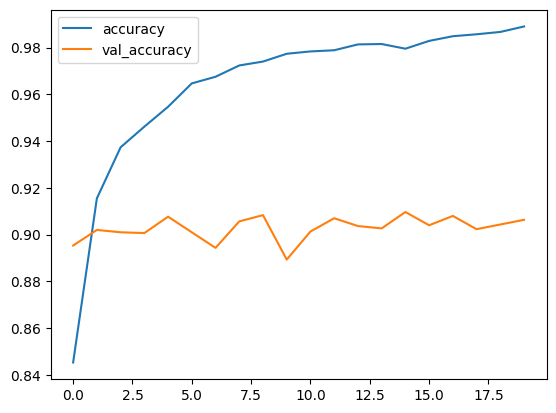

In [ ]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

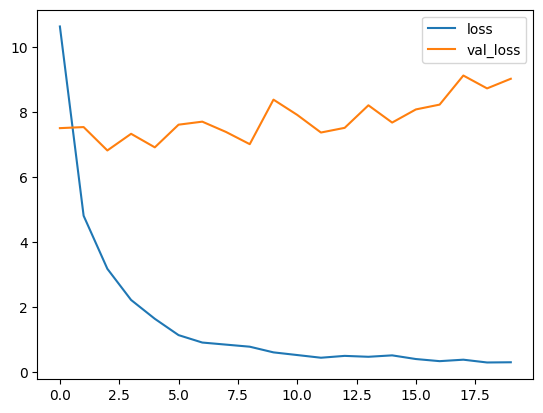

In [ ]:
metrics[['loss','val_loss']].plot()
plt.show()

report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_transfere_learning_feature_extraction.keras). Were you able to beat the benchmark? by how much? (10 points)

In [ ]:
print(test_features.shape)


(5022, 5, 5, 512)


In [ ]:
test_model = keras.models.load_model("fe_cnn_model.h5")
test_model.evaluate(test_features,test_labels)

157/157 [==============================] - 1s 3ms/step - loss: 6.5915 - accuracy: 0.9020


[6.591545581817627, 0.9020310640335083]

Yes. I was able to beat my benchmark. I beat it by 17%.

4. Now it is time to do transfer learning with fine-tuning a pretrained model.






Whatever model architecture you picked from keras.api (vgg16, exception or etc), make sure you unfreeze the last 4 layers (or any other number depending on the model you chose). (5 points)

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

create your own neural network! (the input of this dense network is the same as your original input image (180*180*3) because we are fine-tuning our own model.  (10 points)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # we pick very low learning rate to limit the magnitude of changes we make to the last 3 conv layers we are fine-tuning.
              metrics=["accuracy"])

report the model.summary(). How many parameters does not NN architecture has? how many of the are trainable and how many are no-trainable? (5 points)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_11 (Dense)            (None, 128)               1638

There is a total of 16353990 parameters. Feature extraction had 1639302 parameters. There are 8718726 trainable parameters and 7635264 untrainable parameters.

train your model using model.fit(). Make sure you save the best one by adding the modelcheckpoint to your callback list. (5 points)

In [ ]:
modelcheckpoint  = ModelCheckpoint(filepath="ft_cnn_model",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [ ]:
history = model.fit(train_dataset,
                              epochs=30, validation_data=validation_dataset,
                              callbacks=callback_list)

Epoch 1/30
188/188 [==============================] - 35s 174ms/step - loss: 3.8831 - accuracy: 0.5205 - val_loss: 0.7070 - val_accuracy: 0.7890
Epoch 2/30
188/188 [==============================] - 35s 183ms/step - loss: 0.9495 - accuracy: 0.7515 - val_loss: 0.5153 - val_accuracy: 0.8463
Epoch 3/30
188/188 [==============================] - 33s 176ms/step - loss: 0.6087 - accuracy: 0.8225 - val_loss: 0.4460 - val_accuracy: 0.8800
Epoch 4/30
188/188 [==============================] - 36s 191ms/step - loss: 0.4153 - accuracy: 0.8735 - val_loss: 0.4246 - val_accuracy: 0.8873
Epoch 5/30
188/188 [==============================] - 32s 170ms/step - loss: 0.2990 - accuracy: 0.9138 - val_loss: 0.4505 - val_accuracy: 0.8870
Epoch 6/30
188/188 [==============================] - 38s 202ms/step - loss: 0.2421 - accuracy: 0.9287 - val_loss: 0.4241 - val_accuracy: 0.9037
Epoch 7/30
188/188 [==============================] - 32s 168ms/step - loss: 0.1770 - accuracy: 0.9457 - val_loss: 0.4284 - val_ac

plot the loss vs epoch graph! as well as accuracy vs epoch graph. (10 points)

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,3.883112,0.520500,0.706972,0.789000
1,0.949532,0.751500,0.515336,0.846333
2,0.608690,0.822500,0.446040,0.880000
3,0.415323,0.873500,0.424610,0.887333
4,0.298973,0.913833,0.450517,0.887000


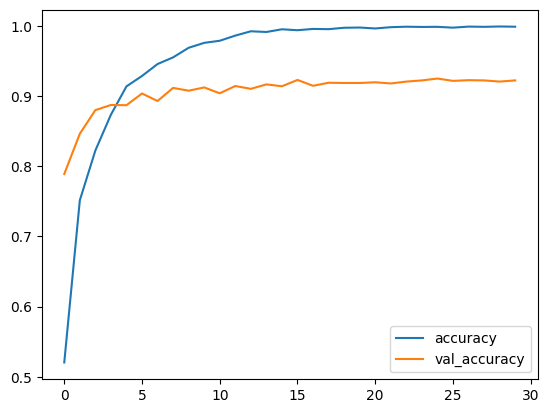

In [ ]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

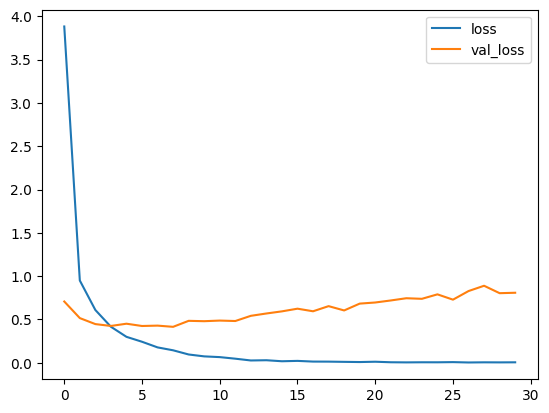

In [ ]:
metrics[['loss','val_loss']].plot()
plt.show()

report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_transfere_learning_fine_tuning.keras). Were you able to beat the benchmark? how about beating the feature extraction model? (10 points)

In [ ]:
test_model = keras.models.load_model("ft_cnn_model")
test_model.evaluate(test_dataset)

157/157 [==============================] - 15s 95ms/step - loss: 0.4439 - accuracy: 0.8957


[0.4438764452934265, 0.8956590890884399]

The accuracy was 89.57. Fine-tuning beat the base model accuracy by 16.37%. The Feature extraction model also beat the fine-tuning model by 0.63%.

5. Excellent job my friend! Now let's have some fun. Can you go ahead and visualize 9 images from the test set that the model misclassified? What is your accuracy (as human being) on these 9 misclassified images by the machine!

157/157 [==============================] - 0s 2ms/step
Misclassified indices: [   0    7   14   31   54   67   72   99  105  111  118  130  134  136
  137  143  155  158  159  163  170  179  181  211  215  219  231  235
  254  259  292  296  326  329  345  350  353  359  363  368  375  379
  384  399  402  423  460  465  466  469  478  481  489  493  499  501
  507  520  537  539  540  554  558  564  568  569  573  576  586  607
  611  642  644  646  648  649  655  689  694  713  718  720  721  723
  728  745  754  757  764  777  779  788  792  803  810  822  825  829
  831  837  847  856  883  897  926  946  950  959  964  973  974  983
 1036 1039 1049 1078 1079 1097 1103 1112 1116 1119 1122 1137 1148 1157
 1167 1178 1180 1182 1214 1251 1254 1257 1264 1265 1297 1303 1306 1307
 1308 1318 1328 1331 1332 1346 1348 1357 1378 1379 1403 1435 1450 1469
 1475 1493 1510 1518 1522 1527 1550 1557 1562 1564 1565 1566 1601 1607
 1618 1637 1651 1657 1665 1683 1697 1705 1734 1739 1748 1749 1757 1774

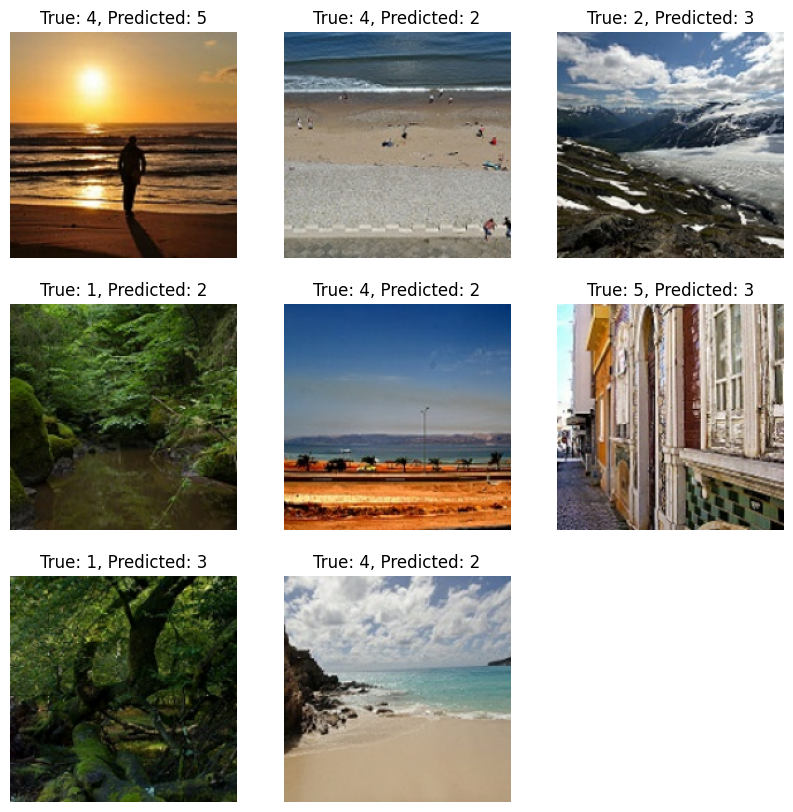

In [ ]:
model = keras.models.load_model("fe_cnn_model.h5")
import numpy as np


# Make predictions on the test features
test_predictions = model.predict(test_features)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class indices

# Find the indices of misclassified images
misclassified_indices = np.where(test_predictions != test_labels)[0]
print(f"Misclassified indices: {misclassified_indices}")

# Select a subset of misclassified images (up to 9)
num_images_to_show = 9
sample_misclassified_indices = misclassified_indices[:min(len(misclassified_indices), num_images_to_show)]
print(f"Sample misclassified indices: {sample_misclassified_indices}")

# Initialize lists to store the misclassified images and labels
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Iterate through the test dataset to collect misclassified images
for i, (images, labels) in enumerate(test_dataset.unbatch()):
    if i in sample_misclassified_indices:
        if labels.numpy() != test_predictions[i]:
            misclassified_images.append(images.numpy())
            misclassified_true_labels.append(labels.numpy())
            misclassified_predicted_labels.append(test_predictions[i])
            print(f"Collected misclassified image at index: {i}")
        else:
            print(f"Skipping correctly classified image at index: {i}")
    if len(misclassified_images) == num_images_to_show:
        break

# Visualize the misclassified images
plt.figure(figsize=(10, 10))
for i in range(len(misclassified_images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i].astype("uint8"))  # Convert the image to uint8 format
    plt.title(f"True: {misclassified_true_labels[i]}, Predicted: {misclassified_predicted_labels[i]}")
    plt.axis("off")
plt.show()